#RoViST-VG Demo

The beginning of this notebook is the demo code for training the RoViST-VG model. The last section will provide steps on how to calculate the VG-Score from the trained model.

## Setup

### Pip Installs and Imports

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.5 MB 14.1 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
     |████████████████████████████████| 6.8 MB 49.0 MB/s 
     |████████████████████████████████| 895 kB 41.2 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 1.2 MB 14.0 MB/s 


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd 
import numpy as np
import json
import os 
from PIL import Image
import datetime
%pylab inline
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from transformers import ViTFeatureExtractor, ViTModel

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Download Data

Please download and unzip the Flickr30k Entities data into the current working directory from the following link: [download link](https://drive.google.com/file/d/1AA3VoQtBY9wZEHG2K0PqGqzc89kYOfT8/view?usp=sharing) 

(You can replace the wget command in the following cell)


In [ ]:
### DOWNLOAD IMAGES ###
!wget --header="Host: doc-10-50-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_kalqqtkfvspenavrni8dvae4pqdav05i_nonce=o1nhiev9ce2vi" --header="Connection: keep-alive" "https://doc-10-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/n1pslr6srmgg68q52bfe32k1e3sfgcem/1644885600000/01091172001417006453/01091172001417006453/1AA3VoQtBY9wZEHG2K0PqGqzc89kYOfT8?e=download&authuser=0&nonce=o1nhiev9ce2vi&user=01091172001417006453&hash=s89fbu003pbaf7587jf1vrivjg6ti99p" -c -O 'flickr30k-entities.zip'
!unzip flickr30k-entities.zip

### rename directory
os.rename("/content/content", "/content/data")

Streaming output truncated to the last 5000 lines.
  inflating: content/flickr30k-entities/2506050069_[219, 336, 330, 415].jpg  
  inflating: content/flickr30k-entities/1211184847_[38, 31, 105, 105].jpg  
  inflating: content/flickr30k-entities/3560620846_[1, 179, 143, 497].jpg  
  inflating: content/flickr30k-entities/3756112747_[143, 147, 216, 218].jpg  
  inflating: content/flickr30k-entities/4390538370_[1, 66, 106, 374].jpg  
  inflating: content/flickr30k-entities/3692055291_[22, 135, 126, 270].jpg  
  inflating: content/flickr30k-entities/440375442_[131, 164, 149, 188].jpg  
  inflating: content/flickr30k-entities/4851047049_[309, 147, 451, 280].jpg  
  inflating: content/flickr30k-entities/549998716_[195, 132, 308, 399].jpg  
  inflating: content/flickr30k-entities/1001573224_[297, 213, 316, 246].jpg  
  inflating: content/flickr30k-entities/350426761_[220, 200, 485, 394].jpg  
  inflating: content/flickr30k-entities/352016884_[144, 56, 430, 374].jpg  
  inflating: content/flick

In [ ]:
### sanity check that all images are there 

images_list = os.listdir("/content/data/flickr30k-entities")
assert len(images_list) == 278464

Please download the GLoVe word embeddings here into the current directory: [download link](https://drive.google.com/file/d/1ZxH7IEldH_iugFgILjaPVDenDqBtbdbO/view?usp=sharing)   


In [ ]:
!wget --header="Host: doc-0s-50-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_kalqqtkfvspenavrni8dvae4pqdav05i_nonce=sre2v7fho25mk" --header="Connection: keep-alive" "https://doc-0s-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/hc3b46odpcv4rmq0l4cahviahe5p5mte/1644885975000/01091172001417006453/01091172001417006453/1ZxH7IEldH_iugFgILjaPVDenDqBtbdbO?e=download&authuser=0&nonce=sre2v7fho25mk&user=01091172001417006453&hash=iakat7aa1cp2o36jtqg4nguv41k7birg" -c -O 'glove.6B.300d.txt'

--2022-02-15 00:46:44--  https://doc-0s-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/hc3b46odpcv4rmq0l4cahviahe5p5mte/1644885975000/01091172001417006453/01091172001417006453/1ZxH7IEldH_iugFgILjaPVDenDqBtbdbO?e=download&authuser=0&nonce=sre2v7fho25mk&user=01091172001417006453&hash=iakat7aa1cp2o36jtqg4nguv41k7birg
Resolving doc-0s-50-docs.googleusercontent.com (doc-0s-50-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0s-50-docs.googleusercontent.com (doc-0s-50-docs.googleusercontent.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1037962819 (990M) [text/plain]
Saving to: ‘glove.6B.300d.txt’

glove.6B.300d.txt   100%[===================>] 989.88M  98.0MB/s    in 10s     

2022-02-15 00:46:55 (97.7 MB/s) - ‘glove.6B.300d.txt’ saved [1037962819/1037962819]



Please download Flick30k Training and Validation Set: 

**Train**: [download link](https://drive.google.com/file/d/11A1C4D_5ZmhnecMDoNgnEG8lPdLBgJGX/view?usp=sharing)  

**Validation**: [download link](https://drive.google.com/file/d/1vN29qw-pAKfWhbqBlyTNu-BUNftB98vo/view?usp=sharing)   

In [ ]:
### training set ###
!wget --header="Host: doc-0o-50-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_kalqqtkfvspenavrni8dvae4pqdav05i_nonce=1geg9sr2kf9le" --header="Connection: keep-alive" "https://doc-0o-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/a775fd2rir0bj70tgk18nil03lpto9h3/1644887025000/01091172001417006453/01091172001417006453/11A1C4D_5ZmhnecMDoNgnEG8lPdLBgJGX?e=download&authuser=0&nonce=1geg9sr2kf9le&user=01091172001417006453&hash=vepov7663c77mgg395aruhi1b9t1udvl" -c -O 'flickr30k_entities_train_clean.csv'

--2022-02-15 01:05:21--  https://doc-0o-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/a775fd2rir0bj70tgk18nil03lpto9h3/1644887025000/01091172001417006453/01091172001417006453/11A1C4D_5ZmhnecMDoNgnEG8lPdLBgJGX?e=download&authuser=0&nonce=1geg9sr2kf9le&user=01091172001417006453&hash=vepov7663c77mgg395aruhi1b9t1udvl
Resolving doc-0o-50-docs.googleusercontent.com (doc-0o-50-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0o-50-docs.googleusercontent.com (doc-0o-50-docs.googleusercontent.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32643294 (31M) [text/csv]
Saving to: ‘flickr30k_entities_train_clean.csv’

flickr30k_entities_ 100%[===================>]  31.13M   106MB/s    in 0.3s    

2022-02-15 01:05:22 (106 MB/s) - ‘flickr30k_entities_train_clean.csv’ saved [32643294/32643294]



In [ ]:
### validation set ###
!wget --header="Host: doc-04-50-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_kalqqtkfvspenavrni8dvae4pqdav05i=01091172001417006453|1644887025000|re95eeb024i1hb34t1v4l9u211jdinba" --header="Connection: keep-alive" "https://doc-04-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/9ej960c1c7bd0lhtu4pp9rdjvcmr66an/1644887250000/01091172001417006453/01091172001417006453/1vN29qw-pAKfWhbqBlyTNu-BUNftB98vo?e=download&ax=ACxEAsa55G8OLmpFr-fQAlS74j_M3tOx_5FXrnbmBr1EQqJKdACuM1ya4IougFTishfQ-TtnsduiyntsPthIJSFwZpnOwLOAh2gCyguOsXaiwjOOm_B60AUg54XnbUtIS-DtIF2N69XJ0sXk2--dIUCyh8RGL4eot2Vd_EOXnW0DbFG2RoL-47ye9FvSElzywjb0aQoH9mWhI7725zHH1IHY88DpBuj80pVGnal_vis6bxQbLbu2NULu8IM1SnzCxkNNnAKWLmHYNg72CYp6r8dQi93Dc-rDvkUfINf5z44vzIrrPc0sKzfRX00S0Sgpc9HS8vLMYK65xu8nmGTCB8BCCSnvCYLY0AyNSbNnVoMm77woMBfvEzMX2EkUHC8rfAnLrEEAcl8GCDL2XWjHDA4QhrBKHqAU4xIL8812XOYT89MOdXcXdKuw4M_JP3SbL3L-NgZa6ypf_uyaBGfLk-n3AuzkCGidsUDwblBiSCSnK0SjgZNnWchQmLXLIbgeuMOk0JT8Gtcd6Tt2NfE770BO7gRbJI7uNC5Ug8zYcd4q3RjC9bbCJzv8BrqStdUQL4lNVDH3-eMeHGMOnraACRMA4Mgrn3v32YL94GTZHfyqOGV11_s96CZh8e_Dx541VP30rPuUSPH22Li2SUaBj7aHo68bz2wq6_yYX3MYm2E&authuser=0" -c -O 'flickr30k_entities_valid_clean.csv'

--2022-02-15 01:07:43--  https://doc-04-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/9ej960c1c7bd0lhtu4pp9rdjvcmr66an/1644887250000/01091172001417006453/01091172001417006453/1vN29qw-pAKfWhbqBlyTNu-BUNftB98vo?e=download&ax=ACxEAsa55G8OLmpFr-fQAlS74j_M3tOx_5FXrnbmBr1EQqJKdACuM1ya4IougFTishfQ-TtnsduiyntsPthIJSFwZpnOwLOAh2gCyguOsXaiwjOOm_B60AUg54XnbUtIS-DtIF2N69XJ0sXk2--dIUCyh8RGL4eot2Vd_EOXnW0DbFG2RoL-47ye9FvSElzywjb0aQoH9mWhI7725zHH1IHY88DpBuj80pVGnal_vis6bxQbLbu2NULu8IM1SnzCxkNNnAKWLmHYNg72CYp6r8dQi93Dc-rDvkUfINf5z44vzIrrPc0sKzfRX00S0Sgpc9HS8vLMYK65xu8nmGTCB8BCCSnvCYLY0AyNSbNnVoMm77woMBfvEzMX2EkUHC8rfAnLrEEAcl8GCDL2XWjHDA4QhrBKHqAU4xIL8812XOYT89MOdXcXdKuw4M_JP3SbL3L-NgZa6ypf_uyaBGfLk-n3AuzkCGidsUDwblBiSCSnK0SjgZNnWchQmLXLIbgeuMOk0JT8Gtcd6Tt2NfE770BO7gRbJI7uNC5Ug8zYcd4q3RjC9bbCJzv8BrqStdUQL4lNVDH3-eMeHGMOnraACRMA4Mgrn3v32YL94GTZHfyqOGV11_s96CZh8e_Dx541VP30rPuUSPH22Li2SUaBj7aHo68bz2wq6_yYX3MYm2E&authuser=0
Resolving doc-04-50-docs.googleusercontent.com (doc

### Setup GPU

In [ ]:
### use the GPU!!
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using CPU.


## Loading Data

### Dataloader Functions

In [ ]:
def init_glove_model(word_dim = 300): 
    """
    Glove Embedding model. 
    """
    glove_input_file = 'glove.6B.{}d.txt'.format(word_dim)
    word2vec_output_file = 'glove.6B.{}d.txt.word2vec'.format(word_dim)
    glove2word2vec(glove_input_file, word2vec_output_file)

    model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

    return model 

In [ ]:
def collate_fn_contextualized(data):
    """
    Data comes in as list of tuples (tensor images, tokenized phrase)
    Use this to collate data if using BERT embeddings. 

    Note this function and contextualized embeddings were not actually used in the  
    paper. 
    """
    # sort a data list by sequence lenngth
    data.sort(key=lambda x: len(x[1]) , reverse=True)

    images, phrase_tokens = zip(*data)
    max_len = len(phrase_tokens[0])

    token_ids_tensors = [] 
    attention_ids_tensors = []

    for i in range(len(data)): 
        
        tokenized_phrase = phrase_tokens[i]
        phrase_len = len(tokenized_phrase)
        pad_len = max_len - phrase_len

        # tokenizer is a global variable 
        tokenized_phrase.extend(['[PAD]'] * pad_len)
        token_ids = tokenizer.convert_tokens_to_ids(tokenized_phrase)

        attention_ids = [1] * phrase_len + [0] * pad_len

        token_ids_tensors.append(torch.tensor(token_ids))
        attention_ids_tensors.append(torch.tensor(attention_ids))
    
    token_ids_tensors = torch.stack(token_ids_tensors) # (batch_size, max_len)
    attention_ids_tensors = torch.stack(attention_ids_tensors) # (batch_size, max_len)

    if type(images[0]) == torch.Tensor:
        images = torch.stack(list(images)) # (batch_size, 3, 224, 224)
    else: 
        images = list(images) # list of PIL images
    
    batch_data = {"images": images, 
                   "token_ids": token_ids_tensors, 
                   "attention_ids": attention_ids_tensors}

    return batch_data

In [ ]:
def collate_fn_static(data): 
    """
    Data comes in as list of tuples (tensor images, tokenized phrase). 
    Use this to collate data if using glove embeddings. 
    """
    images, phrase_embs = zip(*data)

    if type(images[0]) == torch.Tensor:
        images = torch.stack(list(images)) # (batch_size, 3, 224, 224)
    else: 
        images = list(images) # list of PIL images
    
    batch_data = {"images": images, 
                   "phrase_embeddings": torch.stack(list(phrase_embs))}

    return batch_data

In [ ]:
class Flickr30kEntsLoader(Dataset): 

    def __init__(self, dataframe, image_path, word_emb_model = None,
                 img_model_type = "vision transformer", word_emb_type = "static"): 

        self.dataframe = dataframe 
        self.image_ids = dataframe["image_id"].tolist() 
        self.noun_phrases = dataframe["noun_phrase"].tolist() 
        self.bboxes = dataframe["bbox"].tolist() 

        self.image_path = image_path

        self.preprocess = preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])
        
        self.img_model_type = img_model_type
        self.word_emb_type = word_emb_type

        self.word_emb_model = word_emb_model # glove model.

    def __len__(self): 

        return len(self.dataframe)

    def __getitem__(self, idx): 

        image_id = self.image_ids[idx]
        bbox = self.bboxes[idx]

        image_name = str(image_id) + "_" + bbox + ".jpg"
        img = Image.open(self.image_path + '/' + image_name).convert('RGB')

        # preprocess images if using resnet 
        if self.img_model_type == "resnet": 
            img = self.preprocess(img) # tensor of shape (3, 224, 224)

        phrase = self.noun_phrases[idx]

        if self.word_emb_type == "contextualized": # use bert tokenizer
            tokenized_phrase = self.tokenizer.tokenize(phrase)

            return img, tokenized_phrase

        # use glove embeddings. stop words should already be removed. 
        if self.word_emb_type == "static": 
            tokenized_phrase = nltk.word_tokenize(phrase)
            word_embs = []
            for word in tokenized_phrase: 
                try: 
                    word_embs.append(self.word_emb_model[word])
                except: 
                    word_embs.append(self.word_emb_model["unk"])
            
            phrase_embedding = torch.tensor(np.mean(word_embs, axis = 0))

            return img, phrase_embedding

### Initialize GLoVe and create Dataloaders

In [ ]:
### initialize GloVe embeddings. Takes a few minutes. 

word_emb_model = init_glove_model() 

In [ ]:
data_path = "/content"

train_data = pd.read_csv(data_path + "/flickr30k_entities_train_clean.csv", encoding= 'unicode_escape')
valid_data = pd.read_csv(data_path + "/flickr30k_entities_valid_clean.csv", encoding= 'unicode_escape')

train_data = train_data.drop_duplicates()
valid_data = valid_data.drop_duplicates()

print("Training set shape: ", train_data.shape)
print("Validation set shape: ", valid_data.shape)

Training set shape:  (478751, 7)
Validation set shape:  (87300, 7)


In [ ]:
image_path = "/content/data/flickr30k-entities"

train_dl = Flickr30kEntsLoader(train_data, image_path, 
                               word_emb_model = word_emb_model)
valid_dl = Flickr30kEntsLoader(valid_data, image_path, 
                               word_emb_model = word_emb_model)

train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, 
                                               batch_size = 64, 
                                               collate_fn = collate_fn_static)

valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = False, 
                                                batch_size = 64,
                                                collate_fn = collate_fn_static)

Noun phrase ids: torch.Size([300])


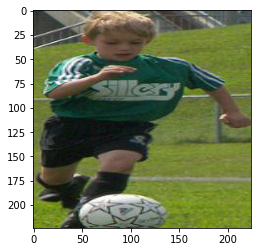

In [ ]:
### test dataloader 

index = 0
plt.imshow(train_dl[index][0])
print("Noun phrase ids: {}".format(train_dl[index][1].shape))

## Model

### Image Encoder

In [ ]:
class ImageEncoder(nn.Module): 

    def __init__(self, model_type, joint_emb_dim, activate_fn = "Tanh"): 
        """
        Encodes image.
        """
        super(ImageEncoder, self).__init__()

        self.model_type = model_type

        if activate_fn == 'Tanh':
            self.activate_fn = nn.Tanh()
        elif activate_fn == 'Leaky ReLU':
            self.activate_fn = nn.LeakyReLU(0.1)
        elif activate_fn == 'Sigmoid': 
            self.activate_fn = nn.Sigmoid()
        else:
            self.activate_fn = nn.ReLU() 

        if self.model_type == "resnet": 
            print("Using ResNet152!")

            self.image_model = models.resnet152(pretrained = True)

            modules = list(self.image_model.children())[:-1]
            self.image_model = nn.Sequential(*modules)
            for p in self.image_model.parameters():
                p.requires_grad = False

            self.linear = nn.Linear(2048, joint_emb_dim)

        elif self.model_type == "vision transformer": 
            print("Using Vision Tranformer!")

            self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
            self.image_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

            self.linear = nn.Linear(768, joint_emb_dim)

    def forward(self, images):
        
        if self.model_type == "resnet": 
            # remember to move images to device 
            images = images.to(device)
            resnet_feats = self.image_model(images) # (batch_size, 2048, 1, 1) 
            output = self.linear(resnet_feats.view(-1, 2048))

        elif self.model_type == "vision transformer": 
      
            img_inputs = self.feature_extractor(images = images, 
                                                return_tensors = "pt")
            
            # remember to move images to device 
            img_inputs = img_inputs['pixel_values'].to(device)

            vit_feats = self.image_model(img_inputs)[1] # (batch_size, 768)
            output = self.linear(vit_feats) 

        output = self.activate_fn(output)  # (batch_size, joint_emb_dim)

        return output 

### Text Encoder

In [ ]:
class TextEncoder(nn.Module): 

    def __init__(self, joint_emb_dim, word_emb_model = None, word_emb_type = "static", 
                 activate_fn = "Tanh", hidden_dim = 300): 
        """
        If using BERT, need to pass in BERT model. 
        """
        super(TextEncoder, self).__init__()

        self.word_emb_model = word_emb_model 
        self.word_emb_type = word_emb_type

        if word_emb_type == "contextualized": 

            self.linear = nn.Linear(1024, joint_emb_dim)

        elif word_emb_type == "static": 
            
            self.linear = nn.Linear(300, joint_emb_dim)

        if activate_fn == 'Tanh':
            self.activate_fn = nn.Tanh()
        elif activate_fn == 'Leaky ReLU':
            self.activate_fn = nn.LeakyReLU(0.1)
        elif activate_fn == 'Sigmoid': 
            self.activate_fn = nn.Sigmoid()
        else:
            self.activate_fn = nn.ReLU() 

    def forward(self, batch_data): 

        # pooled output is second element in tuple 
    
        if self.word_emb_type == "contextualized": # feed through BERT
            output = self.word_emb_model(batch_data["token_ids"].to(device), 
                                             batch_data["attention_ids"].to(device))[1] 
        elif self.word_emb_type == "static": 

            output = self.linear(batch_data["phrase_embeddings"].to(device)) 

        output = self.activate_fn(output) # (batch_size, joint_emb_dim)

        return output 

### Symmetric Loss Function

In [ ]:
class SymmetricLoss(nn.Module):
    """
    Compute Symmetric loss.  
    """
    def __init__(self, gamma = 1.0):
        super(SymmetricLoss, self).__init__()
   
        self.temperature = Variable(torch.tensor(gamma), requires_grad=True)
        self.log_softmax = nn.LogSoftmax(dim = -1)

    def forward(self, image_embeddings, text_embeddings):

        # text to image sims: logits are not softmaxed (batch_size, batch_size)
        logits = (text_embeddings @ image_embeddings.T) * self.temperature

        # image and text similarity with itself. Should have 1s in the diagonals 
        images_sim = image_embeddings @ image_embeddings.T 
        texts_sim = text_embeddings @ text_embeddings.T 

        # softmaxed identity matrix. 
        labels = F.softmax((images_sim + texts_sim)/2 * self.temperature, 
                            dim = -1)

        images_loss = (-labels.T * self.log_softmax(logits.T)).sum(dim = 1)
        texts_loss = (-labels * self.log_softmax(logits)).sum(dim = 1)

        loss = (images_loss + texts_loss)/2 # (batch_size)
        loss = loss.mean()

        return loss 

### Entire Model

In [ ]:
class Region2PhraseModel(nn.Module):
    """
    Entire Model.
    """
    def __init__(self, joint_emb_dim, image_model_type = "vision transformer", 
                 word_emb_model = None, word_emb_type = "static", activate_fn = "Tanh"):
        super(Region2PhraseModel, self).__init__()

        self.image_encoder = ImageEncoder(image_model_type, joint_emb_dim, 
                                          activate_fn = activate_fn)

        self.text_encoder = TextEncoder(joint_emb_dim, word_emb_model, word_emb_type,
                                        activate_fn = activate_fn)

    def l2norm(self, X, dim, eps = 1e-8):
        """
        L2-normalize columns of X
        """
        # sum across the rows 
        norm = torch.pow(X, 2).sum(dim = dim, keepdim = True).sqrt() + eps
        X = torch.div(X, norm)
        
        return X

    def forward(self, batch_data): 

        # returned embedding shape = (batch_size, joint_emb_size)

        image_feats = self.image_encoder(batch_data["images"])
        #image_embeddings = self.l2norm(image_feats, dim = -1)

        text_feats = self.text_encoder(batch_data)
        #text_embeddings = self.l2norm(text_feats, dim = -1)

        return image_feats, text_feats

## Training


### Training Helper Functions

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, epoch, save_path, 
                mode = 'train'): 
    """
    Function to train each epoch. 

    Args: 
        dataloader: either train or valid dataloader. 
        criterion: loss function to use. 
        optimizer: optimizer for training. 
        mode: either "train" or "validate". 
    """
    time1 = datetime.datetime.now()

    if mode == 'train': 
        model.train()
    else: #put model in validation mode 
        model.eval()
        
    #keep track of training and validation loss and accuracy 
    running_loss = 0 

    # mini-batch training with the dataloader 
    for batch_idx, data in enumerate(dataloader): 
      
        batch_data = data
        
        with torch.set_grad_enabled(mode =="train"):
            
            # forward data through model to get logits 
            image_embeddings, text_embeddings = model(batch_data)
       
            # obtain symmetric loss 
            loss = criterion(image_embeddings, text_embeddings)

            if mode == 'train': 
                loss.backward()       # backward the loss and calculate gradients for parameters.
                optimizer.step()      # update the parameters.
                optimizer.zero_grad() # zero the gradient to stop from accumulating
        
        if (batch_idx + 1) % 1 == 0: 
            print("Processed batch: {}. Loss: {}.".format(batch_idx+1, loss.item()))

        # save progress just in case. 
        if (batch_idx + 1) % 1000 == 0 and mode == "train": 
            state = {"epoch": epoch, "model": model.state_dict(), "valid_loss": "None", 
                    "train_loss": running_loss/(batch_idx + 1)}
            model_name = "r2p_epoch{}_batch{}.pth.tar".format(epoch, batch_idx)
            torch.save(state, os.path.join(save_path, model_name))

        running_loss += loss.item()

    # note len(dataloader) is number of batches
    epoch_loss = running_loss/len(dataloader) # len(dataloader) = no. of examples / batch size 
    time2 = datetime.datetime.now()

    return epoch_loss, (time2-time1).total_seconds()


In [ ]:
def train_model(model, training_info, opt = None, start_epoch = 0): 
    """
    Function for model training. 

    Args:
        model: initialised pytorch model (class)
        training_info: dict of loader, criterion and optimizer information. 
        opt: the parsed arguments. 
        start_epoch: starting epoch. Will be >0 if loaded model checkpoint. 
    """

    MIN_LOSS = float('inf')
    EARLY_STOPPING_COUNT = 0
    EVAL_EVERY_EPOCH = 1
    
    scheduler = training_info["scheduler"]

    for epoch in range(start_epoch, training_info["num_epochs"]): 

        # forward training data through model
        train_loss, runtime = train_epoch(model, 
                                           training_info["train_loader"], 
                                           training_info["criterion"],
                                           training_info["optimizer"],
                                           epoch, 
                                           training_info["save_path"],
                                           mode = 'train')

        print("Epoch:%d, train loss: %.4f, time: %.2fs" %(epoch+1, train_loss, runtime))
        
        if (epoch + 1) % EVAL_EVERY_EPOCH == 0: 
            valid_loss, runtime = train_epoch(model, 
                                             training_info["valid_loader"], 
                                             training_info["criterion"],
                                             training_info["optimizer"],
                                             epoch, 
                                             training_info["save_path"],
                                             mode = 'validate')
                
            print('-'*60)
            print("Epoch:%d, valid loss: %.4f, time: %.2fs" %(epoch+1, valid_loss, runtime))
            print('-'*60)

            """
            CHECK EARLY STOPPING CONDITIONS
            """
            if valid_loss < MIN_LOSS:
                MIN_LOSS = valid_loss
                EARLY_STOPPING_COUNT = 0

                # save the best model so far 
                state = {"epoch": epoch, "model": model.state_dict(), "valid_loss": valid_loss, 
                        "train_loss": train_loss}
                model_name = "r2p_model_epoch{}.pth.tar".format(epoch)
                torch.save(state, os.path.join(training_info["save_path"], model_name))
            else: 
                EARLY_STOPPING_COUNT += 1
            
            if EARLY_STOPPING_COUNT == training_info["num_es_epochs"]:
                break
            
            # apply learning rate decay
            scheduler.step() 

### Train Model

In [ ]:
### initialise model
model = Region2PhraseModel(1024, image_model_type = "vision transformer",
                           word_emb_model = None,
                           word_emb_type = "static",
                           activate_fn = "Tanh")

model = model.to(device)
print(model)

Using Vision Tranformer!
Region2PhraseModel(
  (image_encoder): ImageEncoder(
    (activate_fn): Tanh()
    (image_model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=Fal

In [ ]:
### optimizer and loss functions
criterion = SymmetricLoss(gamma = 1.0)
optimizer = optim.Adam(model.parameters(), lr = 0.00005, 
                        weight_decay = 1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.95)

Set the save path to where you want the trained model to save.

In [ ]:
save_path = "/content" 

training_info  = {"num_epochs": 50,
                "criterion": criterion, 
                "optimizer": optimizer,
                "scheduler": scheduler, 
                "num_es_epochs": 10,  
                "train_loader": train_dataloader,
                "valid_loader": valid_dataloader,
                "save_path": save_path}

resume = None # path to where model is saved 

if resume: 
    ### start training model from loaded check point 
    if os.path.isfile(resume):
        checkpoint = torch.load(resume)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint["epoch"] + 1 

        print("Loaded model checkpoint! Starting at epoch: {}".format(start_epoch))
        train_model(model, training_info, start_epoch = start_epoch)
else: 
    ### train model from scratch 
    print("Training model from scratch!")
    train_model(model, training_info)

## VG-Score Calculation (Inference)

The following details the steps for using a trained model to calculate the visual grounding score. 

###  STEP 1: Download VIST Entities Data

**VIST Entities Bounding box regions**: [download link](https://drive.google.com/file/d/14lJHWhIQbc0D2khXubz9VyhKIhg57f3-/view?usp=sharing) 

In [ ]:
!wget --header="Host: doc-08-50-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_kalqqtkfvspenavrni8dvae4pqdav05i_nonce=75tuggg5idd8a" --header="Connection: keep-alive" "https://doc-08-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/5fvbh72uho24q2ha8t7q0larcn4bo09m/1644888675000/01091172001417006453/01091172001417006453/14lJHWhIQbc0D2khXubz9VyhKIhg57f3-?e=download&authuser=0&nonce=75tuggg5idd8a&user=01091172001417006453&hash=e5i5k5unl550ci5dml9qqfm9o1pr8c9v" -c -O 'vist-entities2.zip'

--2022-02-15 01:32:28--  https://doc-08-50-docs.googleusercontent.com/docs/securesc/7kgsp37ueou2iob822ka25iskagriljd/5fvbh72uho24q2ha8t7q0larcn4bo09m/1644888675000/01091172001417006453/01091172001417006453/14lJHWhIQbc0D2khXubz9VyhKIhg57f3-?e=download&authuser=0&nonce=75tuggg5idd8a&user=01091172001417006453&hash=e5i5k5unl550ci5dml9qqfm9o1pr8c9v
Resolving doc-08-50-docs.googleusercontent.com (doc-08-50-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-08-50-docs.googleusercontent.com (doc-08-50-docs.googleusercontent.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10388696813 (9.7G) [application/zip]
Saving to: ‘vist-entities2.zip’

vist-entities2.zip  100%[===================>]   9.67G   162MB/s    in 75s     

2022-02-15 01:33:44 (132 MB/s) - ‘vist-entities2.zip’ saved [10388696813/10388696813]



In [ ]:
### takes around 10 minutes to unzip
os.mkdir("vist-entities")
!unzip vist-entities2.zip -d vist-entities

In [ ]:
!unzip vist-entities2.zip -d vist-entities

Streaming output truncated to the last 5000 lines.
  inflating: vist-entities/9095400_[324.0, 30.4375, 780.0, 561.0].jpg  
  inflating: vist-entities/2688789659_[521.5, 167.75, 665.5, 211.75].jpg  
  inflating: vist-entities/4460715275_[514.0, 174.125, 760.0, 578.5].jpg  
  inflating: vist-entities/57229092_[313.0, 61.21875, 396.5, 428.5].jpg  
  inflating: vist-entities/11685432914_[309.25, 162.25, 465.75, 535.5].jpg  
  inflating: vist-entities/5938403525_[52.96875, 161.75, 135.0, 254.25].jpg  
  inflating: vist-entities/2249605656_[7.3515625, 394.75, 799.0, 596.5].jpg  
  inflating: vist-entities/4433572284_[517.5, 175.25, 573.5, 257.0].jpg  
  inflating: vist-entities/4706950474_[138.25, 57.09375, 524.5, 594.0].jpg  
  inflating: vist-entities/459378570_[0.0, 188.875, 365.75, 255.625].jpg  
  inflating: vist-entities/24654315_[321.0, 216.25, 579.0, 410.75].jpg  
  inflating: vist-entities/5865592436_[632.0, 394.25, 714.0, 485.75].jpg  
  inflating: vist-entities/2356557070_[8.86718

### STEP 2: Extract Nouns

To calculate the visual grounding score, you first need to extract nouns from the output stories. The machine-generated stories from the 4 VST models used in the paper can be downloaded [here](https://drive.google.com/drive/folders/1xp-x14jn9UFhaxbQ9hNpzNqpzHp275dQ?usp=sharing)

Modify 'output_story_file' and 'output_noun_file_name' in the code below.

In [ ]:
def extract_nouns(output_stories, output_nouns_fname):
    """
    Extract nouns from the output story and saves to json file. 
    """
    data_dict = {} 

    tags_to_consider = set(["NN", "NNS", "NNP", "NNPS"])
    for story_id in output_stories: 
        
        nouns_in_story = []

        story_sents = nltk.sent_tokenize(output_stories[story_id])

        for sent in story_sents: 

            nouns_in_image = set() # get unique nouns per sent per image

            # odd cases 
            sent = sent.replace("[male]", "male")
            sent = sent.replace("[female]", "female")
            sent = sent.replace("[location]", "location")
            sent = sent.replace("[organization]", "organization")

            pos_tags = nltk.pos_tag(nltk.word_tokenize(sent))
        
            for token, tag in pos_tags: 
                
                # ignore personal pronoun I. You can ignore other pronouns, if you 
                # think they are not too informative. 
                if token == 'i': continue 

                if tag in tags_to_consider: 
                    nouns_in_image.add(token)
            
            nouns_in_story += list(nouns_in_image)

        data_dict[story_id] = nouns_in_story
        
        with open(output_nouns_fname, 'w') as fp:
            json.dump(data_dict, fp)


output_story_file = "/content/arel_stories.json" 
output_noun_file_name = "MCSM_nouns.json" # output file name 

output_stories = json.load(open(output_story_file))

extract_nouns(output_stories, output_noun_file_name)

### STEP 3: Calculate VG-Score from Nouns

To run the script to calculate the visual grounding score, you would need the following: 

1. VIST Entities Bounding Box Info: 
[here](https://drive.google.com/file/d/1EyA2VNwokV1DNuU2EmV6zrozD9Q8Vgg-/view?usp=sharing)
2. Train/Valid/Test Ground Truth Stories (these 3 files must be in same directory and is for the 'path_to_story_info' argument): [train](https://drive.google.com/file/d/1RJp5Fz5AiTMqfBxDVxKtdmoy1BoCHH1u/view?usp=sharing), [valid](https://drive.google.com/file/d/1uvsj-XajLO_d6ozmPB9jr_i0Qe-QapA7/view?usp=sharing), [test](https://drive.google.com/file/d/1WKN9-riLDiYYMUEJw8RNeY42-XkOoCP6/view?usp=sharing)
3. IDF Dictionary: [here](https://drive.google.com/file/d/1Y-WQxuPBfCjXMhF2QNaL9DziY_6ZG7aR/view?usp=sharing)

4. GloVe Embeddings: [here](https://drive.google.com/file/d/1ZxH7IEldH_iugFgILjaPVDenDqBtbdbO/view?usp=sharing)
5. Model Checkpoint: [here](https://drive.google.com/file/d/10eudslypWf7p8DoA_vPrR8J-_niFyrR8/view?usp=sharing)

6. visual_grounding_scorer.py: [here](https://drive.google.com/file/d/1_uYAnvTVjWqL_AYcn8p9Gu7GguCciyXt/view?usp=sharing)

7. rovist.py: [here](https://drive.google.com/file/d/11xkOaT7Z-odc3Gsunb2GtpoqY6maQUvb/view?usp=sharing)

And in addition, the VIST Entities data downloaded from STEP 1. Then run following command to generate the scores. This will output a CSV (vg_scores.csv) file with the scores.

!python visual_grounding_scorer.py \
--path_to_nouns [File name of noun info produced from STEP2]
--path_to_vist_bbox_info [Path to VIST Entities Bounding Box Info] \
--selected_stories [Story IDs to evaluate, separated by commas] \
--path_to_story_info [Path to Train/Valid/Test Ground Truth Stories] \
--path_to_idf_dict [Path to IDF Dictionary] \
--use_idf [1 for no idf weighting, else 0] \
--img_path [Path to VIST Entities Images from STEP 1] \
--path_to_glove [Path to GLoVe embeddings] \
--model_checkpoint [RoViST-VG Model checkpoint]

Below is an example of what the command may look like:

In [ ]:
!python visual_grounding_scorer.py \
--path_to_nouns "/content/arel_nouns.json" \
--path_to_vist_bbox_info "/content" \
--selected_stories '49800,45531,49990,48121,45840,45595,50195,49615,45536,46191,50150,45615,47165,50041,47835,47870,45715,46050,46005,47440' \
--path_to_story_info "/content" \
--path_to_idf_dict "/content" \
--use_idf 1 \
--img_path "/content/vist-entities" \
--path_to_glove "/content" \
--model_checkpoint "/content/r2p_model_epoch2.pth.tar"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
We are using GPU.
We are using GPU.
Loading GloVe embeddings.
Using Vision Tranformer!
Loading pre-trained model!!!
Using IDF weighting to compute score.
Evaluating 49800
Evaluating 45531
Evaluating 49990
Evaluating 48121
Evaluating 45840
Evaluating 45595
Evaluating 50195
Evaluating 49615
Evaluating 45536
Evaluating 46191
Evaluating 50150
Evaluating 45615
Evaluating 47165
Evaluating 50041
Evaluating 47835
Evaluating 47870
Evaluating 45715
Evaluating 46050
Evaluating 46005
Evaluating 47440
Visual Grounding Score: 3.7705728393187443
